In [89]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Exercise 1. #

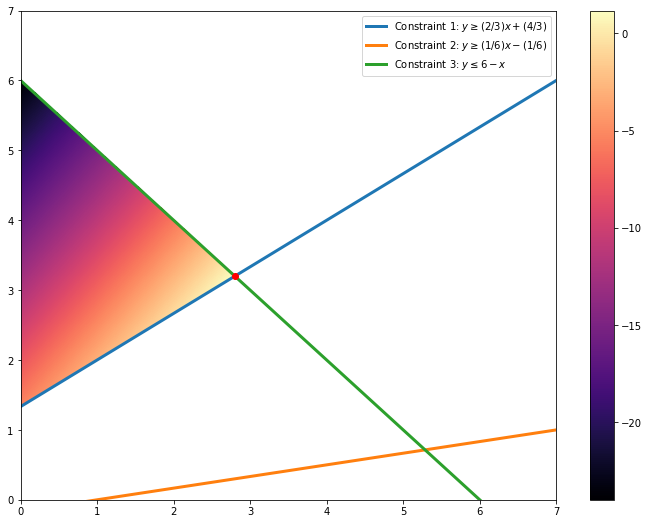

In [127]:
xmin, xmax = 0, 7
ymin, ymax = 0, 7
dens = 1000

x_grid = np.linspace(xmin, xmax, dens)
y_grid = np.linspace(ymin, ymax, dens)
X, Y = np.meshgrid(x_grid, y_grid)
Y = ma.masked_array(Y, mask=(Y < (2 / 3) * X + (4 / 3)) | (Y < (1 / 6) * X - (1 / 6)) | (Y > 6 - X))
Z = 5 * X - 4 * Y

fig = plt.figure(figsize=(12, 9))
plt.pcolormesh(X, Y, Z, cmap='magma')
plt.colorbar()

c1 = (2 / 3) * x_grid + (4 / 3)
c2 = (1 / 6) * x_grid - (1 / 6)
c3 = 6 - x_grid
plt.plot(x_grid, c1, lw=3, label=r'Constraint 1: $y \geq (2 / 3)x + (4 / 3)$')
plt.plot(x_grid, c2, lw=3, label=r'Constraint 2: $y \geq (1 / 6)x - (1 / 6)$')
plt.plot(x_grid, c3, lw=3, label=r'Constraint 3: $y \leq 6 - x$')
plt.plot(2.8, 3.2, 'ro')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

By inspection, the optimizer is at the intersection of constraints 1 and 3, i.e. at the point $(x, y) = (2.8, 3.2)$

# Exercise 2. #

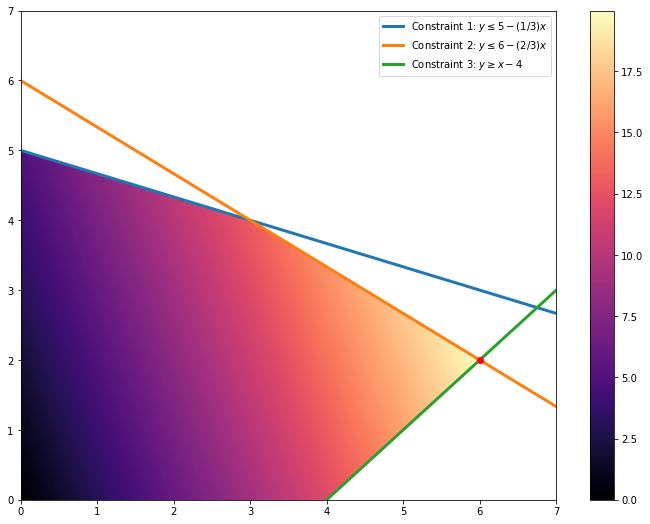

In [129]:
xmin, xmax = 0, 7
ymin, ymax = 0, 7
dens = 1000

x_grid = np.linspace(xmin, xmax, dens)
y_grid = np.linspace(ymin, ymax, dens)
X, Y = np.meshgrid(x_grid, y_grid)
Y = ma.masked_array(Y, mask=(Y > 5 - (1 / 3) * X) | (Y > 6 - (2 / 3) * X) | (Y < X - 4))
Z = 3 * X + Y

fig = plt.figure(figsize=(12, 9))
plt.pcolormesh(X, Y, Z, cmap='magma')
plt.colorbar()

c1 = 5 - (1 / 3) * x_grid
c2 = 6 - (2 / 3) * x_grid
c3 = x_grid - 4
plt.plot(x_grid, c1, lw=3, label=r'Constraint 1: $y \leq 5 - (1 / 3)x$')
plt.plot(x_grid, c2, lw=3, label=r'Constraint 2: $y \leq 6 - (2 / 3)x$')
plt.plot(x_grid, c3, lw=3, label=r'Constraint 3: $y \geq x - 4$')
plt.plot(6, 2, 'ro')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

By inspection, the optimizer is at the intersection of constraints 2 and 3, i.e. at the point $(x, y) = (6, 2)$

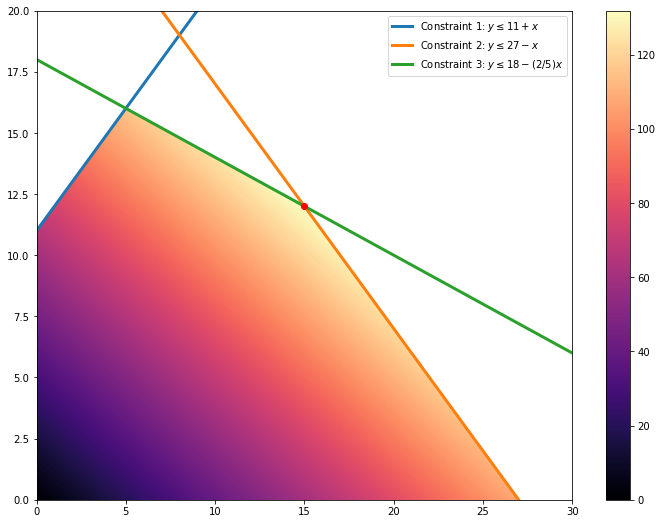

In [183]:
xmin, xmax = 0, 30
ymin, ymax = 0, 20
dens = 1000

x_grid = np.linspace(xmin, xmax, dens)
y_grid = np.linspace(ymin, ymax, dens)
X, Y = np.meshgrid(x_grid, y_grid)
Y = ma.masked_array(Y, mask=(Y > 11 + X) | (Y > 27 - X) | (Y > 18 - (2 / 5) * X))
Z = 4 * X + 6 * Y

fig = plt.figure(figsize=(12, 9))
plt.pcolormesh(X, Y, Z, cmap='magma')
plt.colorbar()

c1 = 11 + x_grid
c2 = 27 - x_grid
c3 = 18 - (2 / 5) * x_grid
plt.plot(x_grid, c1, lw=3, label=r'Constraint 1: $y \leq 11 + x$')
plt.plot(x_grid, c2, lw=3, label=r'Constraint 2: $y \leq 27 - x$')
plt.plot(x_grid, c3, lw=3, label=r'Constraint 3: $y \leq 18 - (2 / 5)x$')
plt.plot(15, 12, 'ro')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

By inspection, the optimizer is at the intersection of constraints 2 and 3, i.e. at the point $(x, y) = (15, 12)$

# Exercise 5. #

In [256]:
class LinearProgram(object):
    def __init__(self, c, A, b, aux=False):
        self.c = np.asarray(c)
        self.A = np.asarray(A)
        self.b = np.asarray(b)
        self.m, self.n = self.A.shape
        assert self.c.shape == (self.n, 1), 'Please enter a vertical c vector with {} elements.'.format(self.n)
        assert self.b.shape == (self.m, 1), 'Please enter a vertical b vector with {} elements.'.format(self.m)
        assert np.all(self.b >= 0), 'Problem is not feasible at the origin.'
        self.non_slack = np.arange(self.n)
        self.slack = np.arange(self.m) + self.n
        self.index_list = np.concatenate((self.slack, self.non_slack))
        self.T = np.concatenate((np.concatenate((np.zeros((1, 1)), -self.c.T, np.zeros((1, self.m)), np.ones((1, 1))), 1), 
                                 np.concatenate((self.b, self.A, np.identity(self.m), np.zeros((self.m, 1))), 1)))
        
    def get_pivot_indices(self):
        pivot_j = None
        pivot_i = None
        ratio_list = []
        for j in range(self.n + 1):
            if self.T[0, j + 1] < 0:
                pivot_j = j
                break
        for i in range(self.m):
            if self.T[i + 1, pivot_j + 1] > 0:
                ratio_list.append((i, self.T[i + 1, 0] / self.T[i + 1, pivot_j + 1]))
        assert ratio_list, 'The problem is unbounded and has no solutions.'
        pivot_i = min(ratio_list, key=lambda x: x[1])[0]
        return pivot_j, pivot_i
    
    def pivot(self):
        if np.all(self.T[0, 1:] >= 0):
            return False
        pivot_j, pivot_i = self.get_pivot_indices()
        index_i = None
        index_j = None
        for k, variable in enumerate(self.index_list):
            if variable == self.slack[pivot_i]:
                index_i = k
            elif variable == self.non_slack[pivot_j]:
                index_j = k
        self.index_list[index_i], self.index_list[index_j] = self.index_list[index_j], self.index_list[index_i]
        self.T[pivot_i + 1, :] /= self.T[pivot_i + 1, pivot_j + 1]
        for i in range(self.m + 1):
            if i == pivot_i + 1:
                pass
            else:
                self.T[i, :] -= self.T[i, pivot_j + 1] * self.T[pivot_i + 1, :]
        print(self.T, '\n')
        return True
    
    def solve(self):
        while self.pivot():
            pass
        basic_dict = dict(zip(self.index_list[:self.m], self.T[1:, 0]))
        non_basic_dict = dict(zip(self.index_list[self.m:], self.T[0, 1:self.n + 1]))
        max_val = self.T[0, 0]
        return max_val, basic_dict, non_basic_dict

In [257]:
lp1 = LinearProgram([[3], [1]], [[1, 3], [2, 3], [1, -1]], [[15], [18], [4]])
print(lp1.solve(), '\n')

[[ 12.   0.  -4.   0.   0.   3.   1.]
 [ 11.   0.   4.   1.   0.  -1.   0.]
 [ 10.   0.   5.   0.   1.  -2.   0.]
 [  4.   1.  -1.   0.   0.   1.   0.]] 

[[ 20.    0.    0.    0.    0.8   1.4   1. ]
 [  3.    0.    0.    1.   -0.8   0.6   0. ]
 [  2.    0.    1.    0.    0.2  -0.4   0. ]
 [  6.    1.    0.    0.    0.2   0.6   0. ]] 

(20.0, {2: 3.0, 1: 2.0, 0: 6.0}, {4: 0.0, 3: 0.0}) 



As shown above, by the simplex algorithm, we have that the optimum value of the objective function is 20.0, and that the optimizer is $(x, y) = (6.0, 2.0)$. This is consistent with the values we found in Exercise 2.

In [258]:
lp2 = LinearProgram([[4], [6]], [[-1, 1], [1, 1], [2, 5]], [[11], [27], [90]])
print(lp2.solve(), '\n')

[[ 108.    0.   -2.    0.    4.    0.    1.]
 [  38.    0.    2.    1.    1.    0.    0.]
 [  27.    1.    1.    0.    1.    0.    0.]
 [  36.    0.    3.    0.   -2.    1.    0.]] 

[[ 132.            0.            0.            0.            2.66666667
     0.66666667    1.        ]
 [  14.            0.            0.            1.            2.33333333
    -0.66666667    0.        ]
 [  15.            1.            0.            0.            1.66666667
    -0.33333333    0.        ]
 [  12.            0.            1.            0.           -0.66666667
     0.33333333    0.        ]] 

(132.0, {2: 14.0, 0: 15.0, 1: 12.0}, {3: 0.0, 4: 0.0}) 



As shown above, by the simplex algorithm, we have that the optimum value of the objective function is 132.0, and that the optimizer is $(x, y) = (15.0, 12.0)$. This is consistent with the values we found in Exercise 2.

# Exercise 7. #

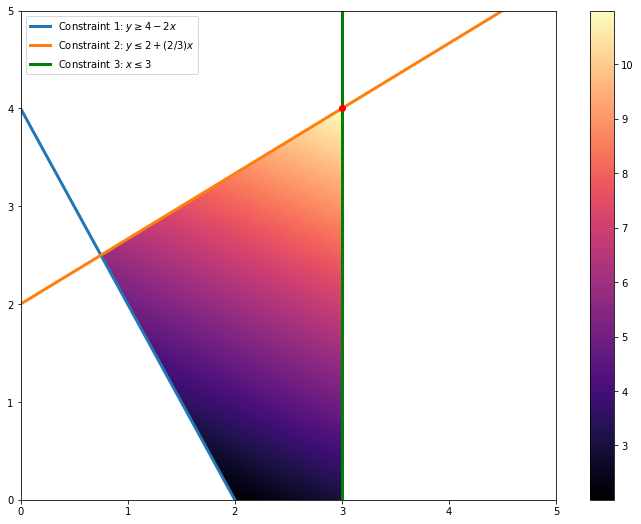

In [216]:
xmin, xmax = 0, 5
ymin, ymax = 0, 5
dens = 1000

x_grid = np.linspace(xmin, xmax, dens)
y_grid = np.linspace(ymin, ymax, dens)
X, Y = np.meshgrid(x_grid, y_grid)
Y = ma.masked_array(Y, mask=(Y < 4 - 2 * X) | (Y > 2 + (2 / 3) * X) | (X > 3))
Z = X + 2 * Y

fig = plt.figure(figsize=(12, 9))
plt.pcolormesh(X, Y, Z, cmap='magma')
plt.colorbar()

c1 = 4 - 2 * x_grid
c2 = 2 + (2 / 3) * x_grid
plt.plot(x_grid, c1, lw=3, label=r'Constraint 1: $y \geq 4 - 2x$')
plt.plot(x_grid, c2, lw=3, label=r'Constraint 2: $y \leq 2 + (2 / 3)x$')
plt.axvline(3, lw=3, c='g', label=r'Constraint 3: $x \leq 3$')
plt.plot(3, 4, 'ro')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

By inspection, the optimizer is at the intersection of constraints 2 and 3, i.e. at the point $(x, y) = (3, 4)$ with a value of 11.

/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:2530: UserWarning: Warning: converting a masked element to nan.
  y = array(b, copy=False, subok=True, ndmin=1)


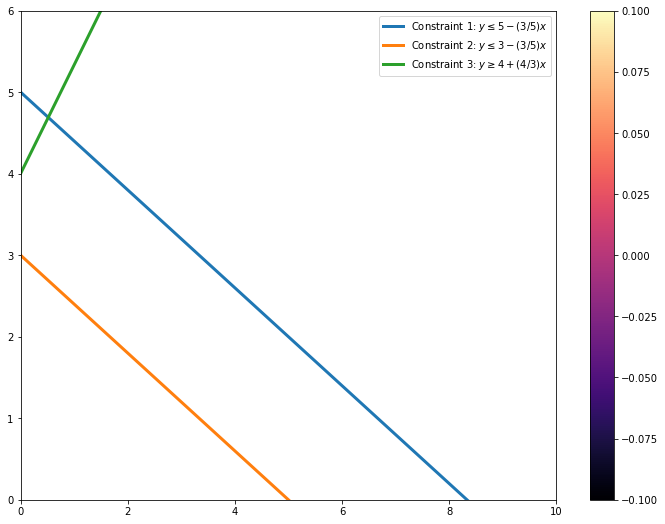

In [232]:
xmin, xmax = 0, 10
ymin, ymax = 0, 6
dens = 100

x_grid = np.linspace(xmin, xmax, dens)
y_grid = np.linspace(ymin, ymax, dens)
X, Y = np.meshgrid(x_grid, y_grid)
Y = ma.masked_array(Y, mask=(Y > 5 - (3 / 5) * X) | (Y > 3 - (3 / 5) * X) | (Y < 4 + (4 / 3) * X))
Z = 5 * X + 2 * Y

fig = plt.figure(figsize=(12, 9))
plt.pcolormesh(X, Y, Z, cmap='magma')
plt.colorbar()

c1 = 5 - (3 / 5) * x_grid
c2 = 3 - (3 / 5) * x_grid
c3 = 4 + (4 / 3) * x_grid
plt.plot(x_grid, c1, lw=3, label=r'Constraint 1: $y \leq 5 - (3 / 5)x$')
plt.plot(x_grid, c2, lw=3, label=r'Constraint 2: $y \leq 3 - (3 / 5)x$')
plt.plot(x_grid, c3, lw=3, label=r'Constraint 3: $y \geq 4 + (4 / 3)x$')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

In this case, the problem is infeasible.

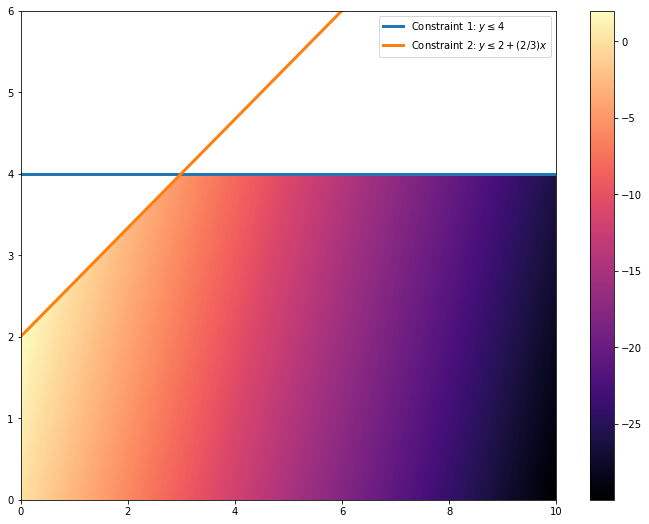

In [235]:
xmin, xmax = 0, 10
ymin, ymax = 0, 6
dens = 1000

x_grid = np.linspace(xmin, xmax, dens)
y_grid = np.linspace(ymin, ymax, dens)
X, Y = np.meshgrid(x_grid, y_grid)
Y = ma.masked_array(Y, mask=(Y > 4) | (Y > 2 + (2 / 3) * X))
Z = -3 * X + Y

fig = plt.figure(figsize=(12, 9))
plt.pcolormesh(X, Y, Z, cmap='magma')
plt.colorbar()

c1 = 4 * np.ones(dens)
c2 = 2 + (2 / 3) * x_grid
c3 = 4 + (4 / 3) * x_grid
plt.plot(x_grid, c1, lw=3, label=r'Constraint 1: $y \leq 4$')
plt.plot(x_grid, c2, lw=3, label=r'Constraint 2: $y \leq 2 + (2 / 3)x$')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.legend()
plt.show()

In this case, the problem is unbounded. However, we can see that the solution is at $(x, y) = (0, 2)$ with a value of 2.

# Exercise 13. #

We know that the problem is not infeasible, since $x = 0$ is always feasible. So, we know that either the problem has an optimum point, or that the problem is unbounded. Suppose the problem has a nonzero optimum point, call it $z$. Consider a row of $A$, call it $A_i$. Then we have that $A_{i}z \leq 0$, so $A_{i}cz = cA_{i}z \leq 0$ for $c \in \mathbb{R}_+$. So, we have that the $cz$ is feasible $\forall$ $c \in \mathbb{R}_+$, so the problem is unbounded.

# Exercise 17. #

Consider a linear optimization problem:
\begin{align*}
\text{maximize}& \quad c^{T}x \\
\text{subject to}& \quad Ax \leq b \ , \\
& \quad x \geq 0
\end{align*}
Then we have that the dual problem is:
\begin{align*}
\text{maximize}& \quad -b^{T}y \\
\text{subject to}& \quad -A^{T}y \leq -c \ , \\
& \quad y \geq 0
\end{align*}
Note that the dual problem is written in standard form.

It follows that the dual of the dual problem is:
\begin{align*}
\text{maximize}& \quad -(-c^{T}x) \\
\text{subject to}& \quad -(-(A^{T})^{T}x) \leq -(-b) \ , \\
& \quad x \geq 0
\end{align*}
This is identical to the original problem.

# Exercise 18. #

In [259]:
lp3 = LinearProgram([[1], [1]], [[2, 1], [1, 3], [2, 3]], [[3], [5], [4]])
print(lp3.solve(), '\n')

[[ 1.5  0.  -0.5  0.5  0.   0.   1. ]
 [ 1.5  1.   0.5  0.5  0.   0.   0. ]
 [ 3.5  0.   2.5 -0.5  1.   0.   0. ]
 [ 1.   0.   2.  -1.   0.   1.   0. ]] 

[[ 1.75  0.    0.    0.25  0.    0.25  1.  ]
 [ 1.25  1.    0.    0.75  0.   -0.25  0.  ]
 [ 2.25  0.    0.    0.75  1.   -1.25  0.  ]
 [ 0.5   0.    1.   -0.5   0.    0.5   0.  ]] 

(1.75, {0: 1.25, 3: 2.25, 1: 0.5}, {2: 0.0, 4: 0.0}) 



<IPython.core.display.Javascript object>


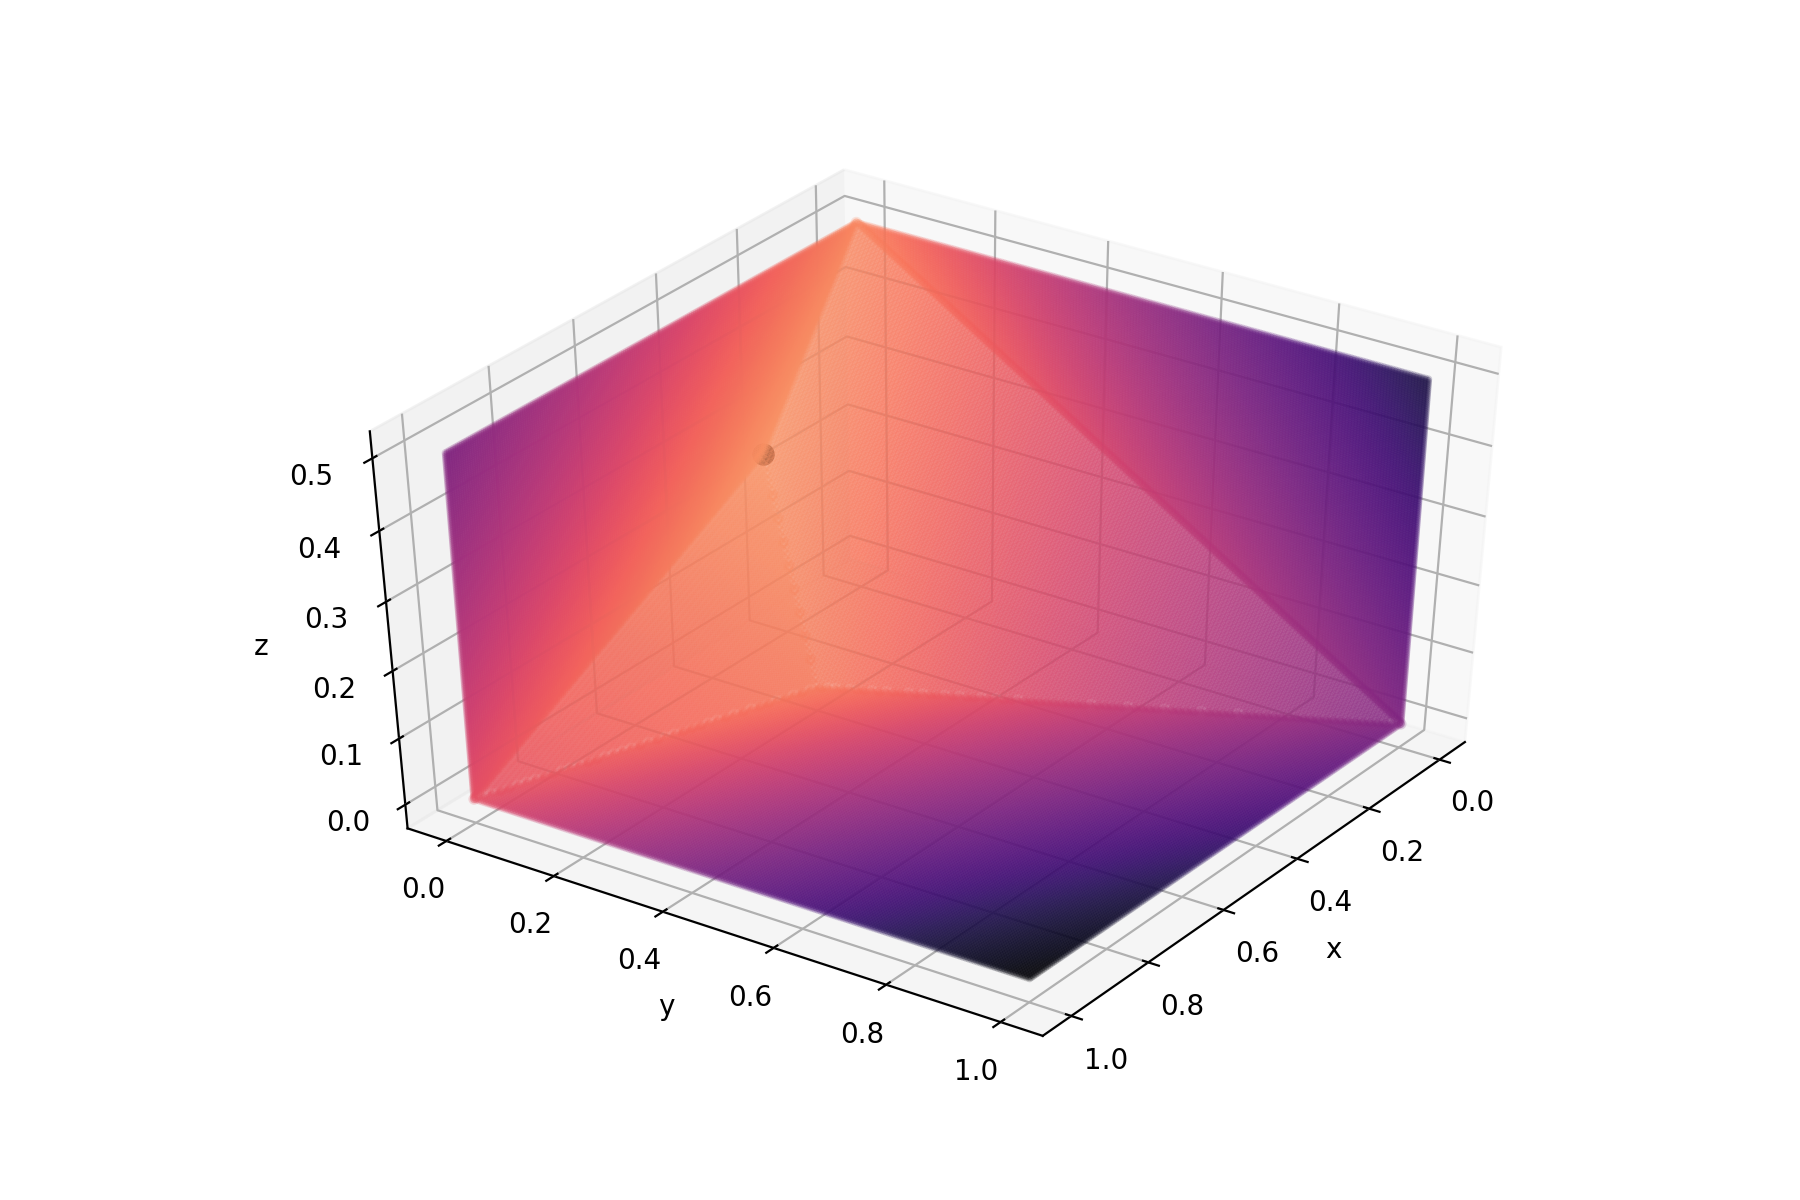

In [4]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cmx
import matplotlib.colors as c

xmin, xmax = 0, 1
ymin, ymax = 0, 1
zmin, zmax = 0, 0.5
dens = 200

x_grid = np.linspace(xmin, xmax, dens)
y_grid = np.linspace(ymin, ymax, dens)
z_grid = np.linspace(zmin, zmax, dens)
X, Y = np.meshgrid(x_grid, y_grid)
Z4, X4 = np.meshgrid(z_grid, x_grid)
Y4 = np.zeros((dens, dens))
Z5, Y5 = np.meshgrid(z_grid, y_grid)
X5 = np.zeros((dens, dens))
Z1 = (1 / 2) - X - (1 / 2)*Y
Z2 = ((1 / 3) - (1 / 3)*X - Y)
Z3 = np.zeros((dens, dens))
Z1 = np.ma.masked_array(Z1, mask=(-X - 3*Y - 3*Z1 > -1) | (Z1 < 0))
Z2 = np.ma.masked_array(Z2, mask=(-2*X - Y - 2*Z2 > -1) | (Z2 < 0))
Z3 = np.ma.masked_array(Z3, mask=(-X - 3*Y - 3*Z3 > -1) | (-2*X - Y - 2*Z3 > -1))
Z4 = np.ma.masked_array(Z4, mask=(-X4 - 3*Y4 - 3*Z4 > -1) | (-2*X4 - Y4 - 2*Z4 > -1))
Z5 = np.ma.masked_array(Z5, mask=(-X5 - 3*Y5 - 3*Z5 > -1) | (-2*X5 - Y5 - 2*Z5 > -1))

raw_data1 = abs((-3 * X - 5 * Y - 4 * Z1).data.ravel())
raw_data2 = abs((-3 * X - 5 * Y - 4 * Z2).data.ravel())
raw_data3 = abs((-3 * X - 5 * Y - 4 * Z3).data.ravel())
raw_data4 = abs((-3 * X4 - 5 * Y4 - 4 * Z4).data.ravel())
raw_data5 = abs((-3 * X5 - 5 * Y5 - 4 * Z5).data.ravel())
raw_data = np.concatenate((raw_data1, raw_data2, raw_data3, raw_data4, raw_data5))

raw_data1 = (raw_data1 / max(raw_data))
colors1 = tuple([plt.cm.magma_r(x) for x in raw_data1])


raw_data2 = (raw_data2 / max(raw_data))
colors2 = tuple([plt.cm.magma_r(x) for x in raw_data2])


raw_data3 = (raw_data3 / max(raw_data))
colors3 = tuple([plt.cm.magma_r(x) for x in raw_data3])


raw_data4 = (raw_data4 / max(raw_data))
colors4 = tuple([plt.cm.magma_r(x) for x in raw_data4])

raw_data5 = (raw_data5 / max(raw_data))
colors5 = tuple([plt.cm.magma_r(x) for x in raw_data5])

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z1, c=colors1, alpha=0.2, s=10)
ax.scatter(X, Y, Z2, c=colors2, alpha=0.2, s=10)
ax.scatter(X, Y, Z3, c=colors3, alpha=0.2, s=3)
ax.scatter(X4, Y4, Z4, c=colors4, alpha=0.2, s=3)
ax.scatter(X5, Y5, Z5, c=colors5, alpha=0.2, s=3)
ax.scatter([0.25], [0.0], [0.25], c='k', s=50, alpha=1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.show()

By inspection, the optimizer is at $(x, y, z) = (0.25, 0, 0.25)$.

So, we have that:

$$1 \cdot 1.25 + 1 \cdot 0.5 = 1.75 = 3 \cdot 0.25 + 5 \cdot 0 + 4 \cdot 0.25$$

Thus, the optimal values are equal, as expected.